# Overview
The famous ARIMA model is basically a Linear Regression model on lags. So what if we replace naive Linear Regression with a state-of-the-art tabular learning algorithm? This is exactly what being implemented in [Sktime], known under the term *reduction*, which refers to the process of aligning the methodologies so that regression solutions can solve forecasting problems. Sktime accepts any regression algorithm that uses Scikit-learn interface, which is a big advantage.

Another pain point in forecasting tasks is that different Python packages such as Statsmodels and Prophet use different fit and predict syntaxes. Sktime serves the role of an unified framework that wraps popular forecasting models such as ARIMA, Holt-Winters and Prophet so that Data Scientists can try different models with ease.

Last but not least, Sktime supports forecasting validation with backtesting and a wide range of metrics.

[Sktime]: https://www.sktime.org/en/stable/index.html

# 1. Forecasting reduction

- For the direct reduction strategy, a separate forecaster is fitted for each step ahead of the forecasting horizon.
- For the recursive strategy, a single estimator is fit for a one-step-ahead forecasting horizon and then called iteratively to predict multiple steps ahead.
- For the hybrid dir-rec strategy, a separate forecaster is fitted for each step ahead of the forecasting horizon and then the previous forecasting horizon is added as an input for training the next forecaster, following the recusrive strategy.
- For the multioutput strategy, a single estimator capable of handling multioutput targets is fitted to all the future steps in the forecasting horizon.

## 1.1. Univariate forecast
In order to reduce a forecasting problem to a regression problem, we need to re-arrange the time series into a table so that itself ($y_t$) becomes the label and its lags ($y_{t-1},y_{t-2},\dots$) become the features. There are three approaches to make prediction to multiple future time steps: recursive reduction, direct reduction and a hybrid between them, implemented in a single function,
<code style='font-size:13px'><a href='https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.compose.make_reduction.html'>make_reduction()</a></code>.

In [9]:
import numpy as np
import pandas as pd
import janitor
import sktime
from sktime.forecasting.compose import make_reduction
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings; warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [10]:
dfTemp = pd.read_csv('data/air_quality.csv')
dfTemp = (
    dfTemp
    .to_datetime('time')
    .select_columns(['time', 'temp'])
    .also(lambda df: display(df.tail()))
    .set_index('time')
    .asfreq('h')
    # .to_period('h')
)

,time,temp
9352,2005-04-04 10:00:00,21.9
9353,2005-04-04 11:00:00,24.3
9354,2005-04-04 12:00:00,26.9
9355,2005-04-04 13:00:00,28.3
9356,2005-04-04 14:00:00,28.5


### Recursive reduction
This is the strategy used in traditional models such as ARIMA and ETS, it trains a model $f:y_{t-1},y_{t-2},\ldots\mapsto y_t$. Denote the last observed value $y_T$, the model first predicts $\hat{y}_{T+1|T}$, then appends it to the original series to predict $\hat{y}_{T+2|T+1}$. This behaviour is repeated until all future time steps have been forecasted. This strategy has a significant weakness, is that it accumulates error each time it makes prediction to a new time step. Hence, requesting forecasts for a large horizon using this strategy is not a good idea, as it can saturate/converge and is no longer accurate.

<img src='image/forecast_reduction_recursive.png' style='height:300px; margin:20px auto 20px;'>

In [6]:
nLags = 5
model = make_reduction(LGBMRegressor(), window_length=nLags, strategy='recursive')
model.fit(dfTemp)
model

RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(), window_length=5)

In [5]:
model.predict(fh=[1,2,3])

,temp
2005-04-04 15:00:00,29.035542
2005-04-04 16:00:00,29.745802
2005-04-04 17:00:00,26.263584


In [19]:
pd.DataFrame({
    'lag': [f'lag{i}' for i in range(5, 0, -1)],
    'importance': model.estimator_.feature_importances_,
}).sort_values('importance')

,lag,importance
2,lag3,411
3,lag2,437
1,lag4,470
0,lag5,735
4,lag1,947


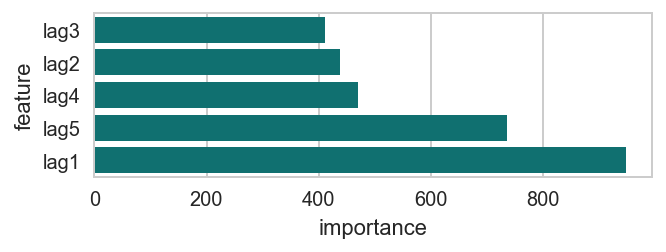

In [16]:
nTop = 10

df = pd.DataFrame({
    'feature': [f'lag{i}' for i in range(nLags, 0, -1)],
    'importance': model.estimator_.feature_importances_
})
df = df.sort_values('importance')
df = df.query("importance > 0")
df = df.tail(nTop)

fig, ax = plt.subplots(figsize=(5,1.5))
sns.barplot(data=df, x='importance', y='feature', color='teal')
plt.show()

### Direct reduction
This strategy, in the other hand, trains a separate model for each time step: $f_h:y_{t-h},y_{t-(h+1)},\ldots\mapsto y_t$. As the number of models need to be train equals to the length of the forecasting horizon, this method is more computationally expensive but more accurate than recursive reduction. Keep in mind that making forecast to a far time step prevents using recent lags ($y_{t-1},\ldots,y_{t-(h-1)}$). In other the words, if $h$ is large then $f_h$ is trained on less features and thus has less prediction power. Also note that because this method is a combination of multiple models, we must specify the future horizon when fitting it to the data.

<img src='image/forecast_reduction_direct.png' style='height:300px; margin:20px auto 20px;'>

In [17]:
nLags = 10
model = make_reduction(LGBMRegressor(), window_length=nLags, strategy='direct', scitype='tabular-regressor')
model.fit(dfTemp, fh=[1,2,3])
model

DirectTabularRegressionForecaster(estimator=LGBMRegressor())

In [21]:
model.predict()

,temp
2005-04-04 15:00:00,26.332280
2005-04-04 16:00:00,29.458241
2005-04-04 17:00:00,25.562921


In [24]:
model.estimators_[0].feature_importances_

array([393, 332, 205, 242, 265, 283, 170, 166, 261, 683], dtype=int32)

### Hybrid
Sktime also develops a hybrid method that combines two above strategies, call *dir-rec*. It also has a recursive behaviour, but after appending $\hat{y}_{T+h|T+(h-1)}$, it trains a new model to predict the next step $\hat{y}_{T+(h+1)|T+h}$. However, because both recursion reduction and direct reduction are not good at forecasting far horizons, *dir-rec* also suffers from this problem.

## 1.2. Multi-label forecast

In [multi-time series](https://joaquinamatrodrigo.github.io/skforecast/0.5.0/user_guides/multi-time-series-forecasting.html) forecasting, two or more time series are modeled together using a single model. Two strategies can be distinguished:

- No-multivariate time series: Used for independent multi series has the same pattern, which means a single model is trained and each predictor is applied independently to others. This process is wrapped in  <code style='font-size:13px'><a href='https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/ForecasterMultiSeries.html'>ForecasterAutoregMultiSeries</a></code> class

- Multivariate time series: All series are modeled in a single model considering that each time series depends not only on its past values but also on the past values of the other series. This process is developing

In [72]:
import numpy as np
import pandas as pd
import janitor

import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries

import warnings; warnings.filterwarnings('ignore')

In [66]:
dfTemp = pd.read_csv('data/air_quality.csv')
dfTemp = (
    dfTemp
    .to_datetime('time')
    .select_columns(['time', 'temp', 'rel_humidity', 'abs_humidity'])
    .set_index('time')
    .asfreq('h')
)
dfTemp.tail()

,temp,rel_humidity,abs_humidity
time,,,
2005-04-04 10:00:00,21.9,29.3,0.7568
2005-04-04 11:00:00,24.3,23.7,0.7119
2005-04-04 12:00:00,26.9,18.3,0.6406
2005-04-04 13:00:00,28.3,13.5,0.5139
2005-04-04 14:00:00,28.5,13.1,0.5028


In [67]:
model = ForecasterAutoregMultiSeries(
    LGBMRegressor(max_depth=4), lags=10,
)
model.fit(dfTemp)
model.predict_interval(steps=7, level='temp')

,pred,lower_bound,upper_bound
2005-04-04 15:00:00,28.141947,25.614435,31.126980
2005-04-04 16:00:00,28.610966,21.052267,32.312756
2005-04-04 17:00:00,28.744962,18.968138,33.600421
2005-04-04 18:00:00,28.744962,16.011985,34.170201
2005-04-04 19:00:00,28.744962,13.875177,34.836653
2005-04-04 20:00:00,28.798401,12.627747,35.356452
2005-04-04 21:00:00,29.233508,8.914352,36.077551


In [74]:
model.get_feature_importance()

,feature,importance
0,lag_1,376
1,lag_2,139
2,lag_3,76
3,lag_4,48
4,lag_5,58
5,lag_6,90
6,lag_7,35
7,lag_8,47
8,lag_9,76
9,lag_10,185


In [76]:
dfTemp.melt(var_name='var')

,var,value
0,temp,13.6000
1,temp,13.3000
2,temp,11.9000
3,temp,11.0000
4,temp,11.2000
...,...,...
28066,abs_humidity,0.7568
28067,abs_humidity,0.7119
28068,abs_humidity,0.6406
28069,abs_humidity,0.5139


In [78]:
model = make_reduction(LGBMRegressor(), window_length=10, strategy='multioutput', scitype='tabular-regressor')
model.fit(dfTemp.melt(var_name='var')['value'], fh=[1,2,3])
model

ValueError: y should be a 1d array, got an array of shape (28059, 3) instead.

# 2. Forecasting validation

## 2.1. Metrics
- https://www.sktime.org/en/stable/api_reference/performance_metrics.html
- https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
- https://www.relexsolutions.com/resources/measuring-forecast-accuracy/

### Regression metrics
R2, RMSE, MSE, MAE

### Percentage-error metrics
https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.mean_absolute_percentage_error.html

### Scaled error metrics
https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.mean_absolute_scaled_error.html#

### Relative-error metrics

## 2.2. Backtesting 

[Backtesting](https://joaquinamatrodrigo.github.io/skforecast/0.5.0/quick-start/introduction-forecasting.html#backtesting-forecasting-models) is a special type of cross-validation which involves moving backward in time step-by-step. Function <code style='font-size:13px'><a href='https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/model_selection.html#skforecast.model_selection.model_selection.backtesting_forecaster'>backtesting_forecaster</a></code> wrapped 3 types of backtest through 2 params  `fixed_train_size` and `refit`:
- Backtesting with refit and increasing training size (fixed origin): The model is trained each time before making predictions, the test size is fixed and the training set increases sequentially. 
- Backtesting with refit and fixed training size (rolling origin): Both the training and testing set rolls forward, therefore, the size of training remains constant. 
- Backtesting without refit: The model is trained only once and not updating sequentially.Thus, this strategy has the advantage of being much faster. However, the model does not incorporate the latest information available, so it may lose predictive capacity over time.

In [65]:
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import plot_residuals

In [63]:
dfTemp = pd.read_excel('data/AirQuality.xlsx')

dfTemp['datetime'] = pd.to_datetime(dfTemp.date.astype(str)+' '+dfTemp.time.astype(str))
dfTemp = dfTemp[['datetime','temp','relativeHumidity','absoluteHumidity']]\
.set_index('datetime').asfreq('h')

train = dfTemp[8500:]
initial_train_size = int(len(train)*0.8)
test = train[initial_train_size:]

In [5]:
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(max_depth=4),
                lags      = 24
             )

In [41]:
metric, pred_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = train['temp'],
                                   initial_train_size = initial_train_size,
                                   fixed_train_size   = False,
                                   steps              = 24,
                                   metric             = 'mean_squared_error',
                                   interval           = [5,95],
                                   refit              = True,
                                   verbose            = False
                               )

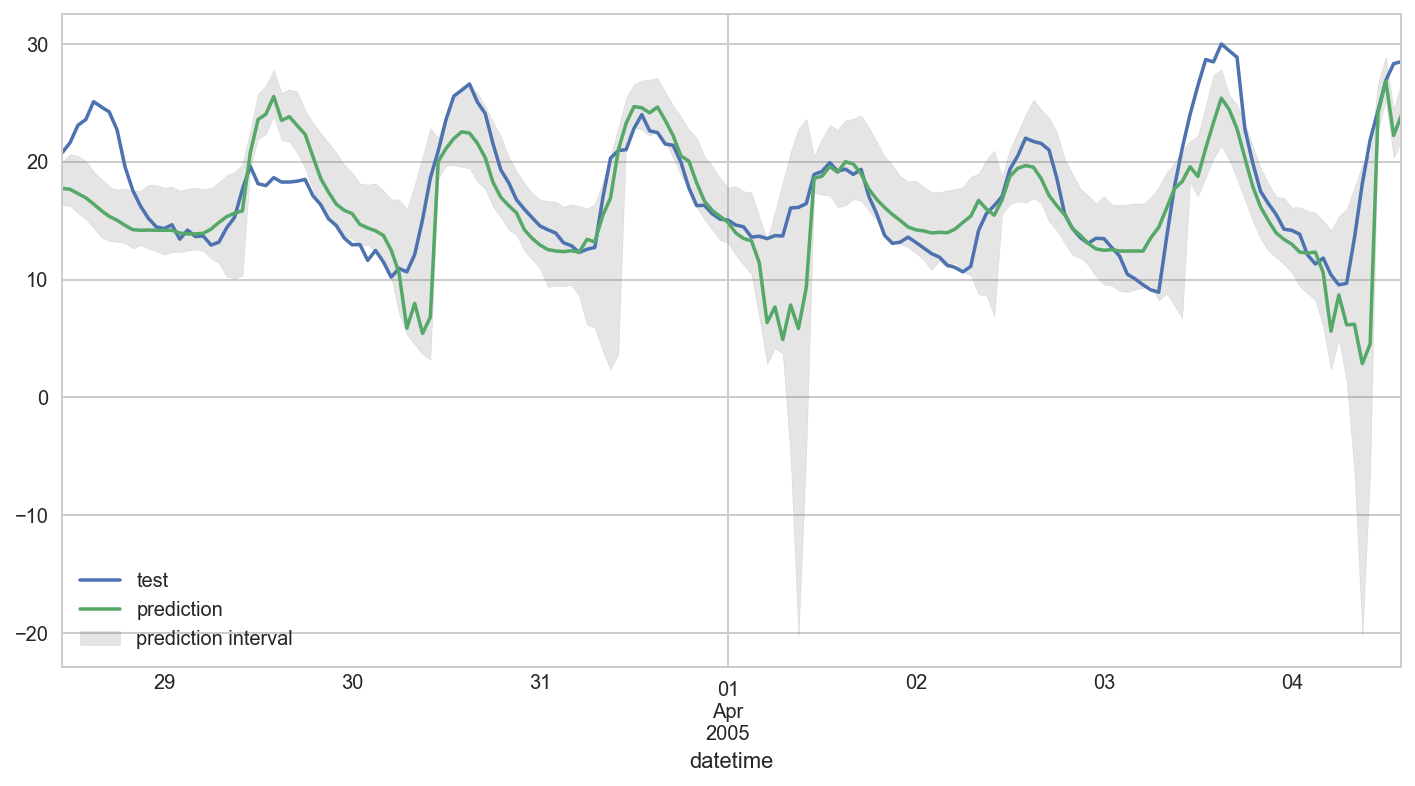

MSE:  15.731294752932119


In [64]:
plot_prediction(test.temp, pred_backtest)

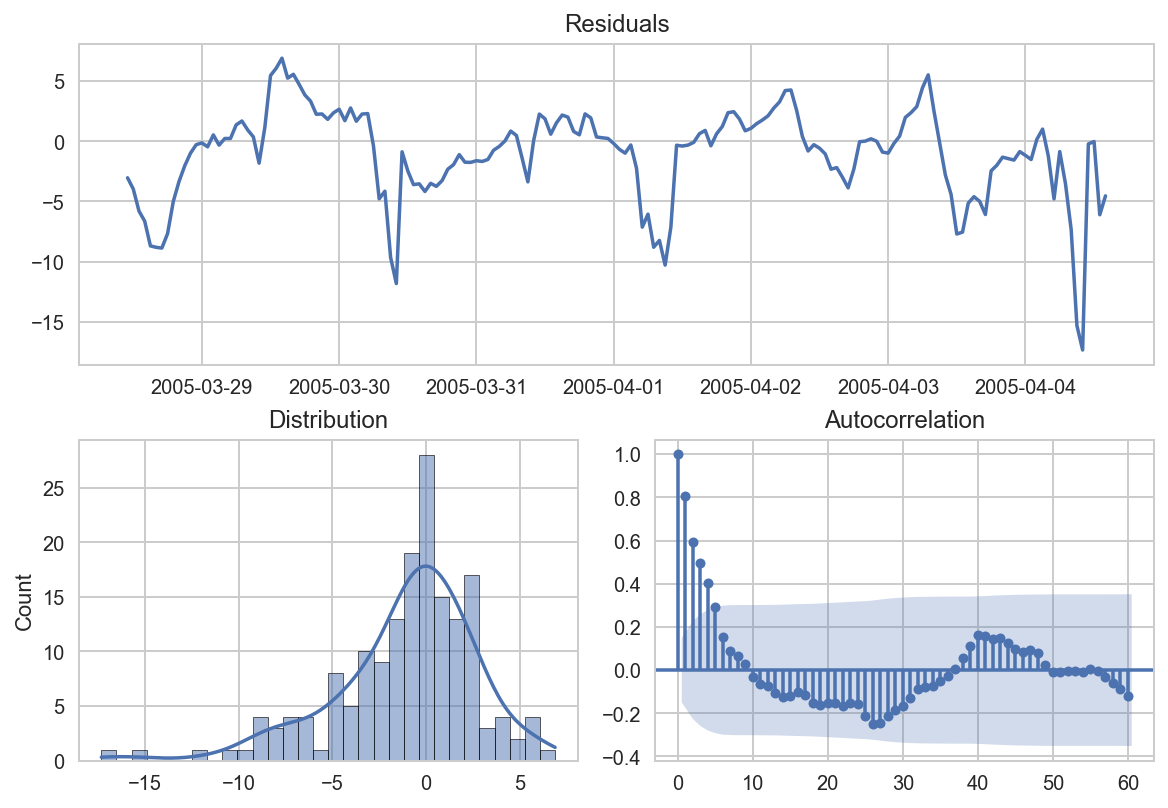

In [67]:
plot_residuals(y_true=test['temp'], y_pred=pred_backtest['pred'])

## 2.3. Hyperparameter tuning

### Grid search  

[GridSearch](https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/model_selection.html#skforecast.model_selection.model_selection.grid_search_forecaster) and [RandomSearch](https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/model_selection.html#skforecast.model_selection.model_selection.random_search_forecaster) has similar syntax

In [22]:
steps = len(test)
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=7),
                lags      = 24
             )

lags_grid = [12, 24, 48]

param_grid = {'n_estimators': [50, 100, 300],
              'learning_rate':[1e-2,1e-3],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = train['temp'],
                    exog        = train[['relativeHumidity','absoluteHumidity']],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(train)*0.5),
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 54.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}
  Backtesting metric: 15.987841871092568



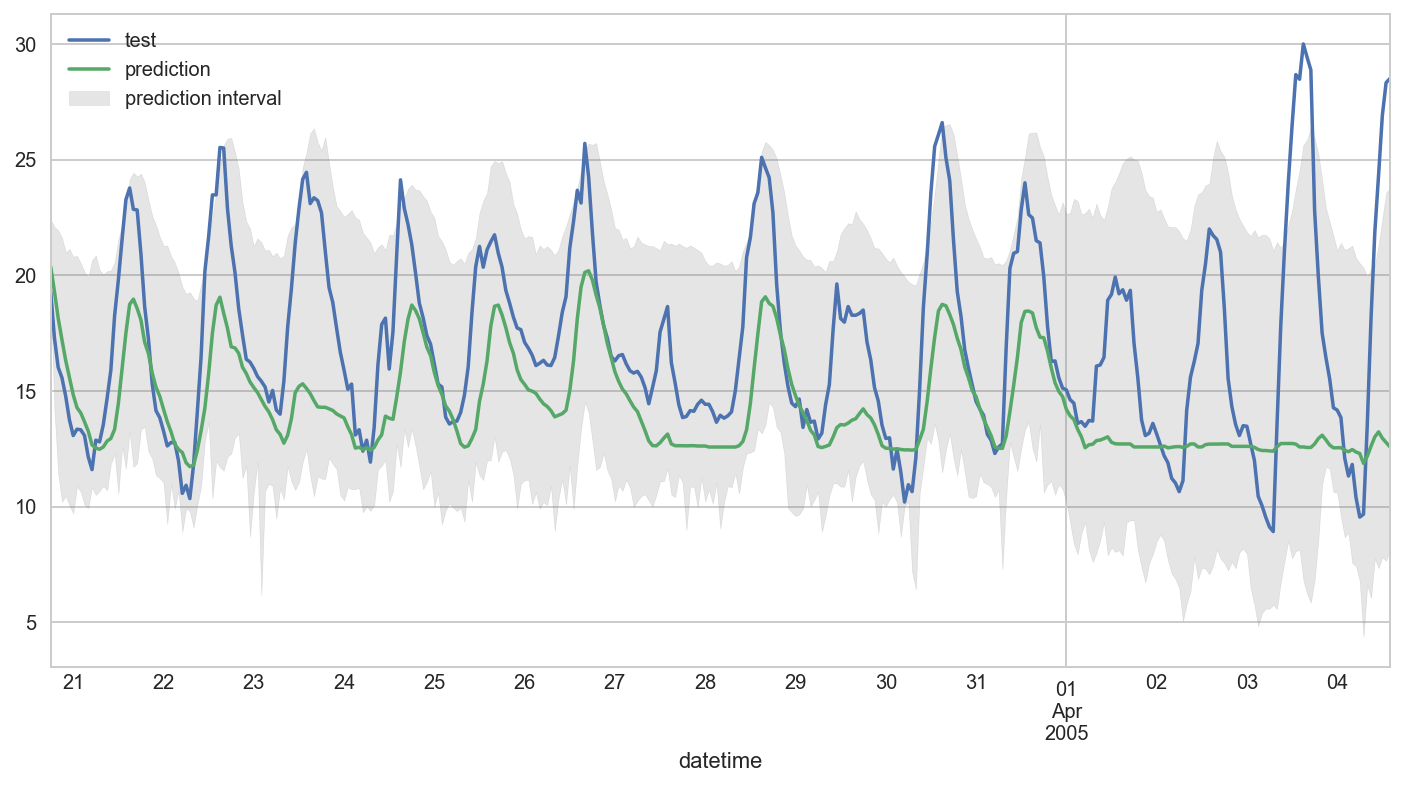

MSE:  20.44993243846528


In [23]:
pred_interval = forecaster.predict_interval(steps=steps, 
                                            exog=test[['relativeHumidity','absoluteHumidity']],
                                            interval = [5,95])

plot_prediction(test.temp, pred_interval)

### Bayesian search 

<code style='font-size:13px'><a href='https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/model_selection.html#skforecast.model_selection.model_selection.bayesian_search_forecaster'>bayesian_search_forecaster</a></code> supports *optuna* and *skpot* engine


In [24]:
from skforecast.model_selection import bayesian_search_forecaster

In [25]:
steps = len(test)
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=7),
                lags      = 24
             )

lags_grid = [12, 24, 48]

In [26]:
def search_space(trial):
    search_space = dict(
            n_estimators = trial.suggest_int('n_estimators', 300, 350),
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2),
            boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
            reg_alpha = trial.suggest_float('reg_alpha', 1e-3, 1e3, log=True),
            reg_lambda = trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True),
        )
    return search_space

In [27]:
results, trial = bayesian_search_forecaster(
                            forecaster            = forecaster,
                            y                     = train.temp,
                            lags_grid             = lags_grid,
                            search_space          = search_space,
                            steps                 = steps,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            fixed_train_size      = True,
                            n_trials              = 10,
                            random_state          = 7,
                            return_best           = True,
                            verbose               = False,
                            engine                = 'optuna',
                            initial_train_size    = int(len(train)*0.5),
                            exog                  = train[['relativeHumidity','absoluteHumidity']],
                            kwargs_create_study   = {},
                            kwargs_study_optimize = {}
                        )

Number of models compared: 30,
         10 bayesian search in each lag configuration.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'n_estimators': 334, 'learning_rate': 0.09887304335154633, 'boosting_type': 'goss', 'reg_alpha': 0.7318244737414893, 'reg_lambda': 0.15679864837306304}
  Backtesting metric: 0.7225709810114573



In [28]:
print("Best param:",forecaster.regressor)

Best param: LGBMRegressor(boosting_type='goss', learning_rate=0.09887304335154633,
              n_estimators=334, random_state=7, reg_alpha=0.7318244737414893,
              reg_lambda=0.15679864837306304)


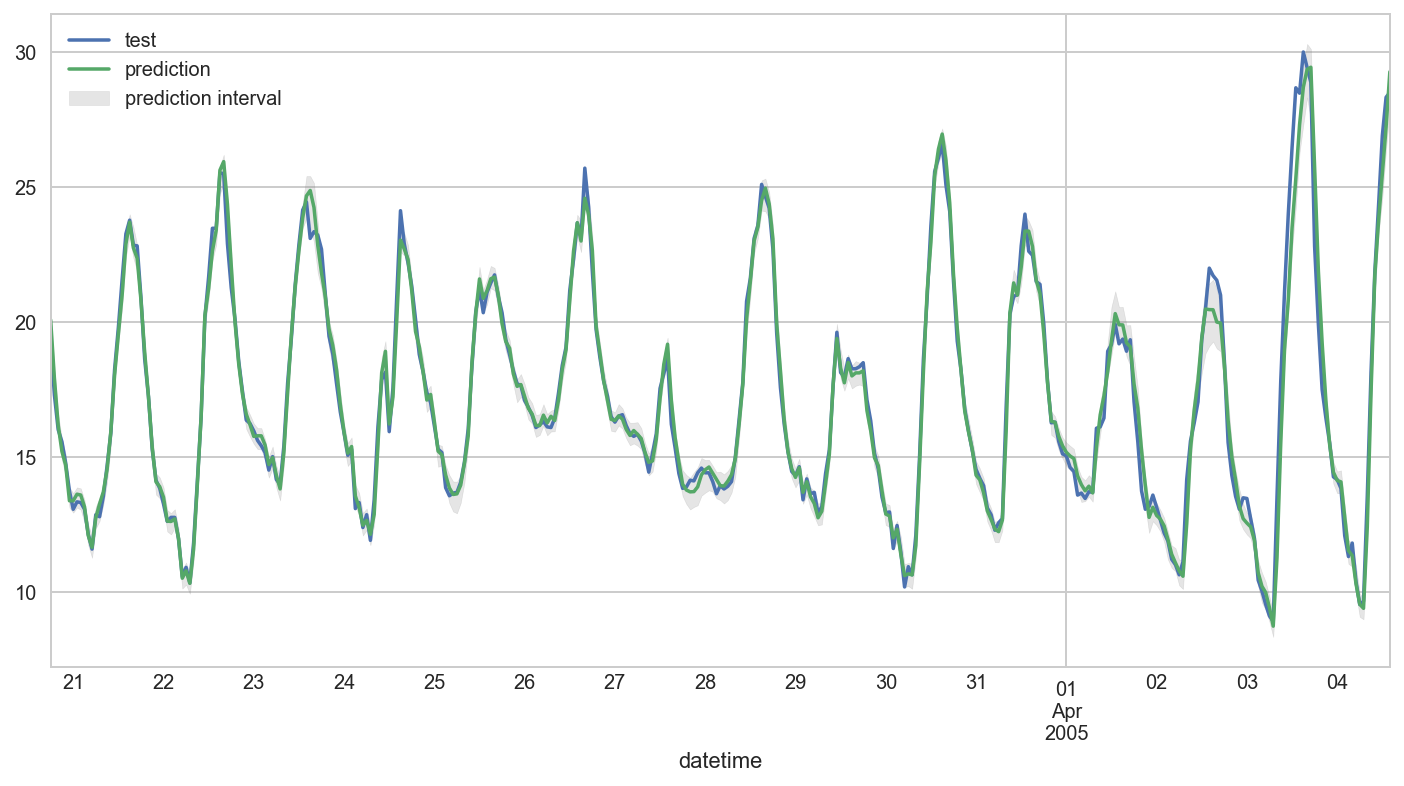

MSE:  0.3634550486831895


In [29]:
pred_interval = forecaster.predict_interval(steps=steps, exog=test[['relativeHumidity','absoluteHumidity']],
                                            interval=[5,95])

plot_prediction(test.temp, pred_interval)

# 5. AutoForecast
In this section, a class <code style='font-size:13px'>AutoForecast</code> combining different forecasting algorithms is developed. It automatically holds a validation set and can plots the results for diagnosis.

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from sspipe import p as f, px as p

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.tbats import TBATS

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2

import warnings; warnings.filterwarnings('ignore')

In [4]:
def format_number(num, decimal=2):
    power = 0
    while True:
        base = num / 10**power
        if 1e-3 <= np.abs(base) < 1e3: break
        elif np.abs(base) < 1e-3: power -= 3
        elif np.abs(base) >= 1e3: power += 3
    strBase = f'{base:.{decimal}f}'
    strPower = '' if power == 0 else f'e{power}'
    out = strBase + strPower
    return out

In [4]:
def grid_search_series(estimator, paramsGrid, sTrain, sTest):
    paramsGrid = ParameterGrid(paramsGrid)
    scoreBest = np.inf
    for params in paramsGrid:
        model = estimator(**params).fit(sTrain)
        sTestPred = model.predict(sTest.index)
        sTestPred[np.isnan(sTestPred)] = 0
        scoreTest = MSE(sTest, sTestPred, squared=False)
        if scoreBest > scoreTest:
            scoreBest = scoreTest
            modelBest = model
    return modelBest, scoreBest

In [5]:
def optimize_arima(sTrain, sTest, sp):
    model = AutoARIMA(
        test='kpss', sp=sp,
        start_p=0, max_p=2, start_q=0, max_q=2, d=0, max_d=2,
        start_P=0, max_P=2, start_Q=0, max_Q=2, D=0, max_D=2,
        suppress_warnings=True,
    )
    model = model.fit(sTrain)
    sTestPred = model.predict(fh=sTest.index)
    score = MSE(sTest, sTestPred, squared=False)
    return model, score

In [6]:
def optimize_ets(sTrain, sTest, sp):
    paramsGrid = {
        'error': ['add', 'mul'],
        'trend': ['add', 'mul'],
        'seasonal': ['add', 'mul'],
        'damped_trend': [True, False],
        'sp': [sp],
    }
    model, score = grid_search_series(AutoETS, paramsGrid, sTrain, sTest)
    return model, score

In [7]:
def optimize_tbats(sTrain, sTest, sp):
    paramsGrid = {
        'use_box_cox': [True, False],
        'use_trend': [True, False],
        'use_damped_trend': [True, False],
        'use_arma_errors': [True, False],
        'sp': [sp],
    }
    model, score = grid_search_series(TBATS, paramsGrid, sTrain, sTest)
    return model, score

In [8]:
def optimize_prophet(sTrain, sTest, sp):
    paramsGrid = {
        'daily_seasonality': [True],
        'yearly_seasonality': [True],
        'growth': ['linear'],
        'n_changepoints': [25],
        'changepoint_range': [0.8, 0.9],
        'seasonality_mode': ['multiplicative', 'additive'],
        'seasonality_prior_scale': [10],
        'changepoint_prior_scale': [0.05],
    }
    model, score = grid_search_series(Prophet, paramsGrid, sTrain, sTest)
    return model, score

In [9]:
class AutoForecast():
    def __init__(self, ts, estimator='ETS', nTest=7, sp=7, beginForecast=None, forcePositive=True): 
        self.series = ts
        self.estimator = estimator.upper()
        self.nTest = nTest
        self.sp = sp
        self.beginForecast = beginForecast
        self.forcePositive = forcePositive
        
        sSeen = self.series[:beginForecast]
        self.sTrain = sSeen[:-nTest]
        self.sTest = sSeen[-nTest:]
        self.fhTest = np.arange(1, self.nTest + 1)
        
        start = dt.datetime.now()
        
        if 'ARIMA' in self.estimator:
            self.model, _ = optimize_arima(self.sTrain, self.sTest, self.sp)
        if 'ETS' in self.estimator or 'HOLT' in self.estimator:
            self.model, _ = optimize_ets(self.sTrain, self.sTest, self.sp)
        if 'TBATS' in self.estimator:
            self.model, _ = optimize_tbats(self.sTrain, self.sTest, self.sp)
        if 'PROPHET' in self.estimator:
            self.model, _ = optimize_prophet(self.sTrain, self.sTest, self.sp) 
                    
        print(dt.datetime.now() - start)
        
    
    def get_forecast(self, nInfer=7, nHistory=0, gamma=(0.95, 0.99)):
        start = 1 - nHistory 
        end = 1 + self.nTest + nInfer
        fhInfer = np.arange(start, end)
        dfCi = self.model.predict_interval(fhInfer, coverage=gamma)
        if self.forcePositive:
            dfCi = dfCi.clip(lower=0)
        dfCi.columns = [f'{bound}_{int(ci*100)}' for ci in gamma for bound in ['lower', 'upper']]
        dfForecast = self.model.predict(fhInfer).rename('forecast').to_frame()
        dfForecast = dfForecast.join(dfCi)
        dfForecast = dfForecast.join(self.series.rename('truth'))
        # dfForecast['run_date'] = dt.date.today()
        return dfForecast
    
    def plot_forecast(self, nInfer=7, nHistory=0, gamma=(0.95, 0.99)):
        sTestPred = self.model.predict(self.fhTest)
        rmse = MSE(self.sTest, sTestPred, squared=False) | f(format_number)
        mae = MAE(self.sTest, sTestPred) | f(format_number)
        r2 = R2(self.sTest, sTestPred) | f(format_number)
        try: 
            modelDetail = self.model.summary().tables[0][1][1].data
        except:
            modelDetail = self.estimator
        title = f'{modelDetail} | RMSE={rmse} | MAE={mae} | R2={r2}'
        
        dfForecast = self.get_forecast(nInfer, nHistory, gamma)

        fig, ax = plt.subplots(figsize=(18,6))
        if nHistory > 0:
            dfForecast.truth[:nHistory].plot(color='black', label='True, seen, fitted')
            dfForecast.truth[nHistory-1:nHistory+self.nTest].plot(color='lightseagreen', label='True, seen, not fitted')
            dfForecast.truth[nHistory+self.nTest-1:].plot(color='indianred', label='True, not seen')
            dfForecast.forecast.plot(style='--', c='grey', label='Forecast')
        else:
            dfForecast.truth[:self.nTest].plot(color='lightseagreen', label='True, seen, not fitted')
            dfForecast.truth[self.nTest-1:].plot(color='indianred', label='True, not seen')
            dfForecast.forecast.plot(style='--', c='grey', label='Forecast')
        
        if self.beginForecast is not None:
            ax.axvline(x=dfForecast.index[nHistory+self.nTest-1], ls=':', c='indianred')
        if nHistory > 0:
            ax.axvline(x=dfForecast.index[nHistory-1], ls=':', c='lightseagreen')
            
        for ci in gamma:
            opacity = 1 - ci + 0.05
            strCi = int(ci*100)
            lower, upper = dfForecast[f'lower_{strCi}'], dfForecast[f'upper_{strCi}']
            ax.fill_between(dfForecast.index, lower, upper, color='grey', alpha=opacity, label=f'CI {strCi}%')
        ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
        ax.set_title(title, fontsize=14)
        plt.show()

In [26]:
dfQty = pd.read_csv('data/weekly_quantity.csv')
dfQty['date'] = dfQty['date'].astype('datetime64')
dfQty = dfQty.set_index('date')
dfQty = dfQty.asfreq('d')
sQty = dfQty.quantity

sTrain = sQty[:-7]
sTest = sQty[-7:]

0:00:02.654598


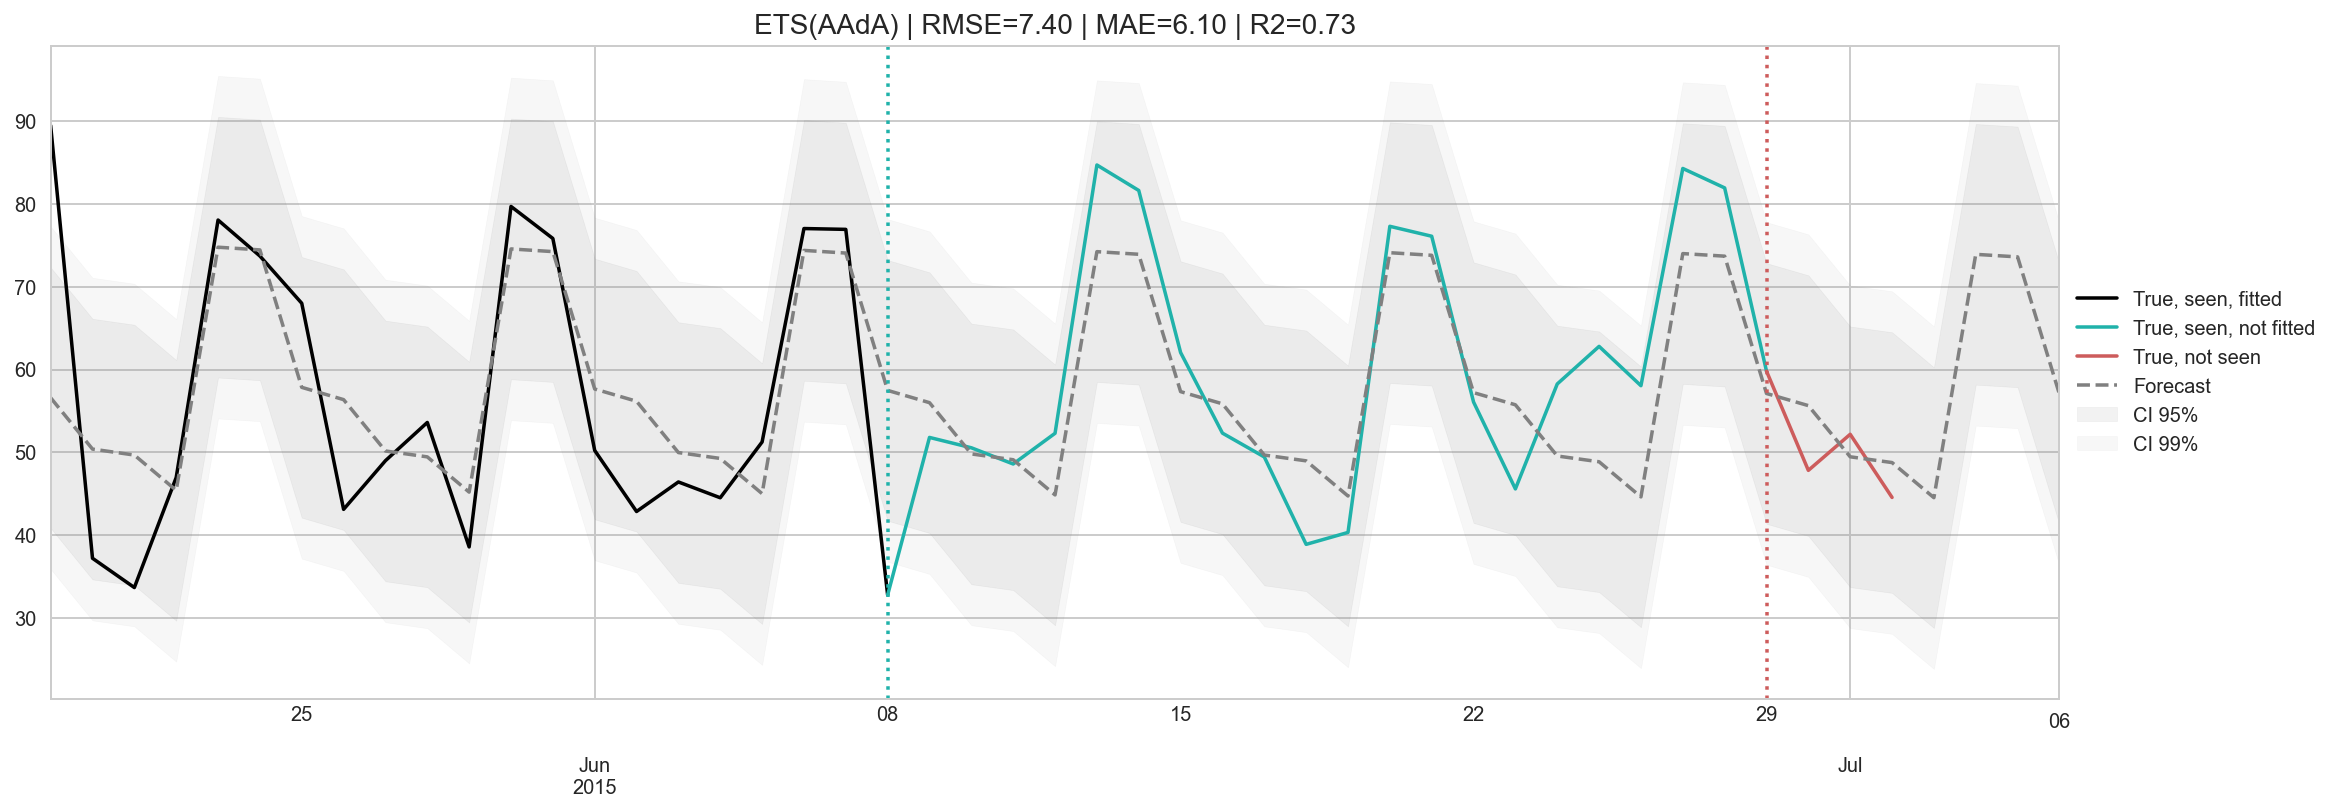

In [27]:
model = AutoForecast(sQty, estimator='ets', beginForecast='2015-06-29', nTest=7*3, sp=7)
model.plot_forecast(nInfer=7, nHistory=7*3)

# References
- *sktime.org - [Forecasting with Sktime](https://nbviewer.org/github/sktime/sktime/blob/4194aacaa105ef59807ea56c1bb3497b37eb1613/examples/01_forecasting.ipynb)*
- https://nbviewer.org/github/sktime/sktime/blob/4194aacaa105ef59807ea56c1bb3497b37eb1613/examples/01_forecasting.ipynb
- https://sites.google.com/site/nttrungmtwiki/home/it/data-mining/time-series-analysis/time-series-forecasting-performance-metrics-comparison

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*